# Notebook Objectives

In this notebooks, we'll go through the main behavioral analysis results.

Results include:
* ?
* ?

---
# Setup


In [1]:
##% title Imports
import os
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LassoCV, Lasso
from scipy import stats

from popy.io_tools import *
from popy.behavior_data_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
from popy.decoding.decoder_tools import *
from popy.plotting.plotting_tools import *
#from popy.plotting.plot_behavior import show_target_selection 
import popy.config as cfg
from popy.plotting.plot_cortical_grid import plot_on_cortical_grid

PATH = cfg.PROJECT_PATH_LOCAL


In [2]:
##% data loading
def load_data_custom(monkey, area=None, subregion=None):
    # load data (meta session)
    floc = os.path.join(PATH, 'data', 'processed', 'neural_data', 'meta_rates_20')
    neural_dataset =  xr.open_dataset(floc + '/meta_rates.nc')

    if area is not None:
        neural_dataset = neural_dataset.sel(unit=neural_dataset.area == area)
    if subregion is not None:
        neural_dataset = neural_dataset.sel(unit=neural_dataset.subregion == subregion)

    neural_dataset = neural_dataset.sel(unit=neural_dataset.monkey == monkey)

    # add coordinates (should be added during the dataset creation)
    neural_dataset = neural_dataset.assign_coords(R_1=('trial_id', [0 if hist in [0, 1, 2, 3] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(R_2=('trial_id', [0 if hist in [0, 1, 4, 5] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(R_3=('trial_id', [0 if hist in [0, 2, 4, 6] else 1 for hist in neural_dataset.history_of_feedback.values]))
    neural_dataset = neural_dataset.assign_coords(fb_sequence=('trial_id', neural_dataset.history_of_feedback.values))
    neural_dataset = neural_dataset.assign_coords(fb_sequence_m1=('trial_id', neural_dataset.history_of_feedback.values%4))
    neural_dataset = neural_dataset.assign_coords(time_m1=('time', neural_dataset.time.values + 7.5))

    # normalize firing rates (z-score)
    neural_data = neural_dataset.firing_rates.values  # Get the firing rates data
    normalized_data = np.zeros_like(neural_data)  # Create a copy to avoid modifying the original data
    for i in range(neural_data.shape[1]):  # Loop through each neuron
        # Get all data for this neuron across trials and timepoints
        neuron_data = neural_data[:, i, :]
        
        # Calculate mean and std across all values for this neuron
        mean_val = np.mean(neuron_data)
        std_val = np.std(neuron_data)
        
        # Z-score normalize and store in the output array
        z_scored_data = (neuron_data - mean_val) / std_val
        normalized_data[:, i, :] = z_scored_data
    neural_dataset.firing_rates.values = normalized_data

    return neural_dataset

In [3]:
# @title Helper Functions

def get_weights_per_area(weights, t=3.5):
    '''
    Get the weights of the PCA components per area
    '''

    # to df, where columns are monkey, session, area, unit, weight
    data_to_df = []
    for unit_temp in weights.unit.values:
        data_to_df.append(
            {'monkey': unit_temp.split('_')[0],
            'session': unit_temp.split('_')[1],
            'area': unit_temp.split('_')[2],
            'unit': "_".join(unit_temp.split('_')[3:]),
            'weight': weights.sel(time=t, unit=unit_temp).values,
            }
        )
    df = pd.DataFrame(data_to_df)

    df['weight_ratio'] =np.abs(df['weight'])/np.sum(np.abs(df['weight']))

    # get best weight per monkey, session, area (drop unit)
    df_abs = df.copy()
    df_abs['weight'] = df_abs['weight'].abs()

    df_best = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'max'}).reset_index()
    df_best = df_best.rename(columns={'weight': 'best_weight'})
    df_best['best_weight_ratio'] = (df_best['best_weight'] / df_abs['weight'].sum()) * 100

    df_sum = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'sum'}).reset_index()
    df_sum = df_sum.rename(columns={'weight': 'sum_weight'})
    df_sum['sum_weight_ratio'] = (df_sum['sum_weight'] / df_abs['weight'].sum()) * 100
    df_best = df_best.merge(df_sum, on=['monkey', 'session', 'area'], how='left')

    df_mean = df_abs.groupby(['monkey', 'session', 'area']).agg({'weight': 'mean'}).reset_index()
    df_mean = df_mean.rename(columns={'weight': 'mean_weight'})
    df_best = df_best.merge(df_mean, on=['monkey', 'session', 'area'], how='left')

    return df_best

def time_resolved_decoder(neural_dataset, target='R_1', group=None, t_project=3.5):
    trial_ids = neural_dataset.trial_id.values
    labels = neural_dataset[target].values  
    cv = 10

    # create train and test splits
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    clf = LogisticRegression()

    coeffs_all = []
    scores_all = []
    projected_data = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(trial_ids, labels)):
        ## 1. Fit and score the model

        # get labels of this fold
        y_train = neural_dataset[target].sel(trial_id=train_idx).values
        y_test = neural_dataset[target].sel(trial_id=test_idx).values

        coeffs_fold = []
        scores_fold = []
        for t in neural_dataset.time.values:
            # get the firing rates for the current time point
            X_train_temp = neural_dataset.firing_rates.sel(trial_id=train_idx, time=t).values
            X_test_temp = neural_dataset.firing_rates.sel(trial_id=test_idx, time=t).values

            # fit the model
            clf.fit(X_train_temp, y_train)
            score = clf.score(X_test_temp, y_test)

            # Store coefficients and R² score
            coeffs_fold.append(clf.coef_)
            scores_fold.append(score)

        coeffs_all.append(coeffs_fold)
        scores_all.append(scores_fold)

        ## 2. project test data to decision boundary at t=3.5
        neural_dataset_train = neural_dataset.sel(trial_id=train_idx)
        neural_dataset_test = neural_dataset.sel(trial_id=test_idx)

        # fit the model
        X_train_temp = neural_dataset_train.firing_rates.sel(time=t_project).values
        clf.fit(X_train_temp, y_train)

        # project test data
        X_test_temp = neural_dataset_test.firing_rates.values
        data_projected = np.array([X_test_temp[trial, :, :].T @ clf.coef_.squeeze() for trial in range(X_test_temp.shape[0])])

        # write back to xarray, preserve the trial and time dimensions and corresponding coordinates
        time_coords = {name: coord for name, coord in neural_dataset_test.coords.items() if 'time' in coord.dims}
        trial_coords = {name: coord for name, coord in neural_dataset_test.coords.items() if 'trial_id' in coord.dims}
        # Create a DataArray with the projected data
        data_projected_da = xr.DataArray(data_projected, dims=('trial_id', 'time'), coords={**trial_coords, **time_coords})
        # add to list
        projected_data.append(data_projected_da.copy())
            
    # convert to numpy array
    coeffs_all = np.array(coeffs_all).squeeze()
    scores_all = np.array(scores_all).squeeze()

    # average over folds
    coeffs_all = np.mean(coeffs_all, axis=0)
    scores_all = np.mean(scores_all, axis=0)

    # create an xarray
    results = xr.DataArray(scores_all, dims=('time'), coords={'time': neural_dataset.time.values})
    weights = xr.DataArray(coeffs_all, dims=('time', 'unit'), coords={'time': neural_dataset.time.values, 'unit': neural_dataset.unit.values})

    # concatenate projected data
    projected_data = xr.concat(projected_data, dim='trial_id')

    return results, weights, projected_data

def add_neural_value_coord(data_projected, neural_dataset):
    V_t = data_projected.sel(time=3.5).values
    V_t_m1 = data_projected.sel(time=-4).values

    data_projected = data_projected.assign_coords(V_t=('trial_id', V_t))
    data_projected = data_projected.assign_coords(V_t_m1=('trial_id', V_t_m1))

    return data_projected

In [4]:
##% Plotting Functions

def plot_decoder_results(results, weights, n_extra_trials):
    fig, axs = plt.subplots(1, 3, figsize=(13, 4))

    ax = axs[0]
    ax.plot(results.time, results)
    ax.axhline(.5, color='k', linestyle='--')
    
    plot_keypoints(ax, n_extra_trials, fontsize=8)
    ax.grid(axis='x')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('R2')
    ax.set_xlabel('Time')
    ax.set_title('R2 score')
    # add colorbar
    ax.set_title('decoder performance (cross val)')

    ax = axs[1]
    # plot bar below
    pbar = ax.imshow(weights.data.T, aspect='auto', cmap='RdBu', extent=[weights.time.min(), weights.time.max(), 0-.5, len(weights.unit)-.5], origin='lower', vmin=-np.max(np.abs(weights.data)*.5), vmax=np.max(np.abs(weights.data)*.5))
    plt.colorbar(pbar, ax=ax, pad=0.005, fraction=.05)
    
    plot_keypoints(ax, n_extra_trials, fontsize=8)
    ax.grid(axis='x', alpha=.5, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Time')
    ax.set_ylabel('Unit')
    ax.set_title('Weights')

    ax = axs[2]
    df_weights = get_weights_per_area(weights, t=3.5)
    plot_on_cortical_grid(df_weights, 'sum_weight_ratio', 
                            bar_title='percentage of weights given by area (%)',
                            ax=ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    return fig, axs

def plot_projected_data(data_projected, title, n_extra_trials, xlim=None):
    # project to axis
    h = 9  # in cm
    w = 12  # in cm

    fig, ax = plt.subplots(figsize=(w/2.54, h/2.54))

    time_vector = data_projected.time.values

    unique_fb_sequences = np.sort(np.unique(data_projected.fb_sequence.data))

    # bwr colormap, n=8 sampples RdYlGn
    colors = sns.color_palette("RdYlGn", len(unique_fb_sequences))[::-1]
    alphas = [1-i for i in np.linspace(0, 1, len(unique_fb_sequences))]
    labels = ["[-, -, -]", "[+, -, -]", "[-, +, -]", "[+, +, -]", "[-, -, +]", "[+, -, +]", "[-, +, +]", "[+, +, +]"][::-1]

    full_mean = np.mean(data_projected, axis=0)

    for i, label in enumerate(unique_fb_sequences[::-1]):
        class_mean = np.mean(data_projected.where(data_projected.fb_sequence == label), axis=0)
        ax.plot(time_vector, class_mean - full_mean, color=colors[i], label=labels[i], linewidth=1, alpha=.7)

    # add behav keyboints
    plot_keypoints(ax, n_extra_trials)
    # y grid only
    ax.grid(axis='x', alpha=.5, linestyle='--')
    ax.axhline(0, color='k', linestyle='-', alpha=.5)

    # remove left and top spines
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    # move legemd outside
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # save as svg
    ax.set_ylabel('neural value')
    '''if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('Neural value')'''
    
    if xlim is not None:    
        ax.set_xlim(xlim)

    return fig, ax

def green_red_plot(data_projected):
    # distribution of pos and neg feedback along neural value
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    V_t = data_projected.V_t.values
    V_t_m1 = data_projected.V_t_m1.values
    R_t_m1 = data_projected.R_1.values

    # get q_t and q_{t-1}
    q_curr = (V_t - np.min(V_t)) / (np.max(V_t) - np.min(V_t)) 
    q_prev = (V_t_m1 - np.min(V_t_m1)) / (np.max(V_t_m1) - np.min(V_t_m1))
    q_diff = q_curr - q_prev
    fb_vector = R_t_m1 
    fb_sequence = data_projected.fb_sequence.values

    ax = axs[0]

    # boxplot of q_curr: x axis is 8 levels of fb_sequence, y axis is q_curr (mean and std and also individual points are shown)
    sns.boxplot(x=fb_sequence, y=q_curr, palette='RdYlGn', ax=ax)
    sns.stripplot(x=fb_sequence, y=q_curr, color='black', size=3, alpha=0.5, ax=ax)

    mean_val = np.mean(q_curr)
    ax.axhline(mean_val, color='k', linestyle='--', label='mean neural value')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)

    ax.set_xlabel('Feedback sequence')
    ax.set_ylabel('Neural value at trial=t\n $V_t$')
    #ax.set_ylim(0, 1)
    # remove outliers
    ax.set_yticks([0, .5, 1])   
    ax.set_yticklabels([0, .5, 1])
    # legend
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax = axs[1]

    ax.hist(q_curr[fb_vector == 1], color='tab:green', alpha=.5, label='value after fb positive', bins=10)
    ax.hist(q_curr[fb_vector == 0], color='tab:red', alpha=.5, label='value after fb negative', bins=10)

    ax.axvline(mean_val, color='k', linestyle='--', label='mean neural value')
    # plot mean firing rate
    ax.set_xlabel('Neural value at trial=t\n $V_t$')
    #ax.set_xlim(0, 1)
    ax.set_ylabel('Count')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # distribution of change in value for each feedback
    ax = axs[2]

    ax.hist(q_diff[fb_vector == 1], color='tab:green', alpha=.5, label='value after fb positive', bins=10)
    ax.hist(q_diff[fb_vector == 0], color='tab:red', alpha=.5, label='value after fb negative', bins=10)
    # line at 0 and means
    ax.axvline(0, color='k', linestyle='-')
    ax.axvline(np.mean(q_diff[fb_vector == 1]), color='tab:green', linestyle='--', label='mean fb positive')
    ax.axvline(np.mean(q_diff[fb_vector == 0]), color='tab:red', linestyle='--', label='mean fb negative')

    ax.set_xlabel('Change in neural value \n$\Delta V = V_t - V_{t-1}$')
    #ax.set_xlim(-.7, .7)

    ax.set_ylabel('Count')
    # legend below plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = axs[3]

    # change in value vs RPE
    RPE_neural = fb_vector - q_prev

    # scatter positive and negative RPEs and fit line
    q_prev_temp = q_prev[fb_vector == 1]
    q_diff_temp = q_diff[fb_vector == 1]
    ax.scatter(q_prev[fb_vector == 1], q_diff[fb_vector == 1], color='tab:green', alpha=.5)
    # fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(q_prev_temp, q_diff_temp)
    fit_line = slope * q_prev_temp + intercept
    ax.plot(q_prev_temp, fit_line, color='tab:green', alpha=.5)

    # scatter negative RPEs
    q_prev_temp = q_prev[fb_vector == 0]
    q_diff_temp = q_diff[fb_vector == 0]
    ax.scatter(q_prev[fb_vector == 0], q_diff[fb_vector == 0], color='tab:red', alpha=.5)
    # fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(q_prev_temp, q_diff_temp)
    fit_line = slope * q_prev_temp + intercept
    ax.plot(q_prev_temp, fit_line, color='tab:red', alpha=.5)


    # line at 0
    ax.axvline(mean_val, color='k', linestyle='--')
    ax.axhline(0, color='k', linestyle='-')
    # legend
    ax.scatter([], [], color='tab:green', label='fb positive')
    ax.scatter([], [], color='tab:red', label='fb negative')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
    ax.set_xlabel('Neural value at trial t-1\n $V_{t-1}$')
    ax.set_ylabel('Change in neural value \n$\Delta V = V_t - V_{t-1}$')
    #ax.set_ylim(-np.max(np.abs(q_diff))*1.1, np.max(np.abs(q_diff))*1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # both axes from -1 to 1

    plt.tight_layout()

    return fig, axs


---
# Get data

In [5]:
monkey, subregion = 'ka', 'vLPFC'

neural_dataset = load_data_custom(monkey, subregion=subregion)

neural_dataset

<xarray.Dataset>
Dimensions:              (unit: 534, time: 1500, trial_id: 160)
Coordinates: (12/17)
    unit_id_original     (unit) int64 ...
    channel              (unit) int64 ...
    monkey               (unit) object ka ka ka ka ka ka ... ka ka ka ka ka ka
    session              (unit) object ...
    area                 (unit) object ...
    subregion            (unit) object 'vLPFC' 'vLPFC' ... 'vLPFC' 'vLPFC'
    ...                   ...
    R_1                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    R_2                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    R_3                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    fb_sequence          (trial_id) float64 0.0 0.0 0.0 0.0 ... 7.0 7.0 7.0 7.0
    fb_sequence_m1       (trial_id) float64 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0 3.0
    time_m1              (time) float64 0.0 0.01 0.02 0.03 ... 14.97 14.98 14.99
Data variables:
    firing_rates         (trial_id, unit, time) float64 -1.01 -1.049 ... -0.8612
Attributes:
    bin_size:  0.01

---
# Section 1: Projection to value subspace

## Define the value subspace

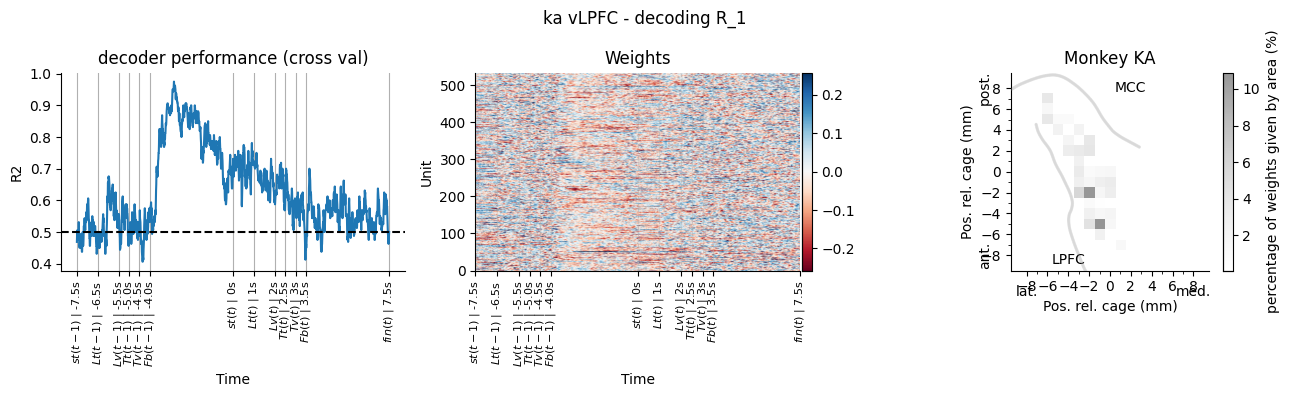

In [6]:
results, weights, data_projected = time_resolved_decoder(neural_dataset, target='R_1', t_project=3.5)

fig, axs = plot_decoder_results(results, weights, n_extra_trials=(-1, 0))

plt.suptitle(f'{monkey} {subregion} - decoding R_1')
plt.tight_layout()

In [7]:
weights

<xarray.DataArray (time: 1500, unit: 534)>
array([[-0.01084868,  0.01555529, -0.04894889, ...,  0.11597067,
         0.08791876, -0.06074847],
       [-0.01861605,  0.00662351, -0.05645395, ...,  0.12213851,
         0.08771445, -0.05706925],
       [-0.02234993, -0.00542391, -0.04738166, ...,  0.12153602,
         0.0774386 , -0.07593638],
       ...,
       [-0.02516562, -0.17369829, -0.11682584, ...,  0.05241181,
         0.13711332,  0.06834092],
       [-0.00324073, -0.20253473, -0.1067921 , ...,  0.0654156 ,
         0.12189937,  0.04688139],
       [ 0.01290158, -0.22426583, -0.09041951, ...,  0.08279304,
         0.10538029,  0.03147446]])
Coordinates:
  * time     (time) float64 -7.5 -7.49 -7.48 -7.47 -7.46 ... 7.46 7.47 7.48 7.49
  * unit     (unit) object 'ka_010822_LPFC_06_01' ... 'ka_310820_LPFC_15_02'

Text(0.5, 0.98, 'ka vLPFC')

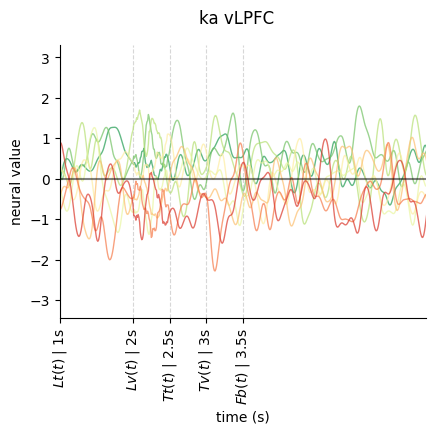

In [8]:
fig, ax = plot_projected_data(data_projected, n_extra_trials=(0, 0), title=None, xlim=[1, 6])
plt.suptitle(f'{monkey} {subregion}')

---
# Section 2: Analysis of the neural value representation

## Green red plot: Value evolves according to feedback

In [9]:
# get neural value for the current trial and the previous one

data_projected = add_neural_value_coord(data_projected, neural_dataset)
data_projected

<xarray.DataArray (trial_id: 160, time: 1500)>
array([[-2.98098135, -2.66645009, -2.81350628, ...,  1.70507069,
         1.73025538,  1.78450763],
       [-1.77480789, -1.43566798, -0.97314663, ...,  1.52437208,
         1.56515015,  1.56989713],
       [-4.31783018, -4.55621748, -4.67438091, ...,  1.24368827,
         1.63151976,  2.07605034],
       ...,
       [ 1.55589733,  1.25855624,  1.52301593, ...,  0.40926157,
         0.7234012 ,  1.09328755],
       [-0.12670683,  0.03264076, -0.07085049, ...,  0.07520481,
        -0.25821515, -0.52417036],
       [-1.84597866, -2.24381082, -2.28856675, ..., -0.27845121,
        -0.31032667, -0.29685491]])
Coordinates:
    history_of_feedback  (trial_id) float64 0.0 0.0 1.0 1.0 ... 6.0 6.0 6.0 7.0
  * trial_id             (trial_id) int64 1 8 22 32 41 ... 108 131 135 138 147
    R_1                  (trial_id) int64 0 0 0 0 0 0 0 0 1 ... 1 1 1 1 1 1 1 1
    R_2                  (trial_id) int64 0 0 0 0 1 1 1 1 0 ... 0 0 0 0 1 1 1 1
    R_3                  (trial_id) int64 0 0 1 1 0 0 1 1 0 ... 0 0 1 1 0 0 0 1
    fb_sequence          (trial_id) float64 0.0 0.0 1.0 1.0 ... 6.0 6.0 6.0 7.0
    fb_sequence_m1       (trial_id) float64 0.0 0.0 1.0 1.0 ... 2.0 2.0 2.0 3.0
  * time                 (time) float64 -7.5 -7.49 -7.48 ... 7.47 7.48 7.49
    epoch                (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0
    time_m1              (time) float64 0.0 0.01 0.02 0.03 ... 14.97 14.98 14.99
    V_t                  (trial_id) float64 1.04 0.1055 -0.2515 ... -4.446 7.886
    V_t_m1               (trial_id) float64 -0.6248 -1.421 ... 9.237 4.835

/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_26597/2147812739.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=fb_sequence, y=q_curr, palette='RdYlGn', ax=ax)


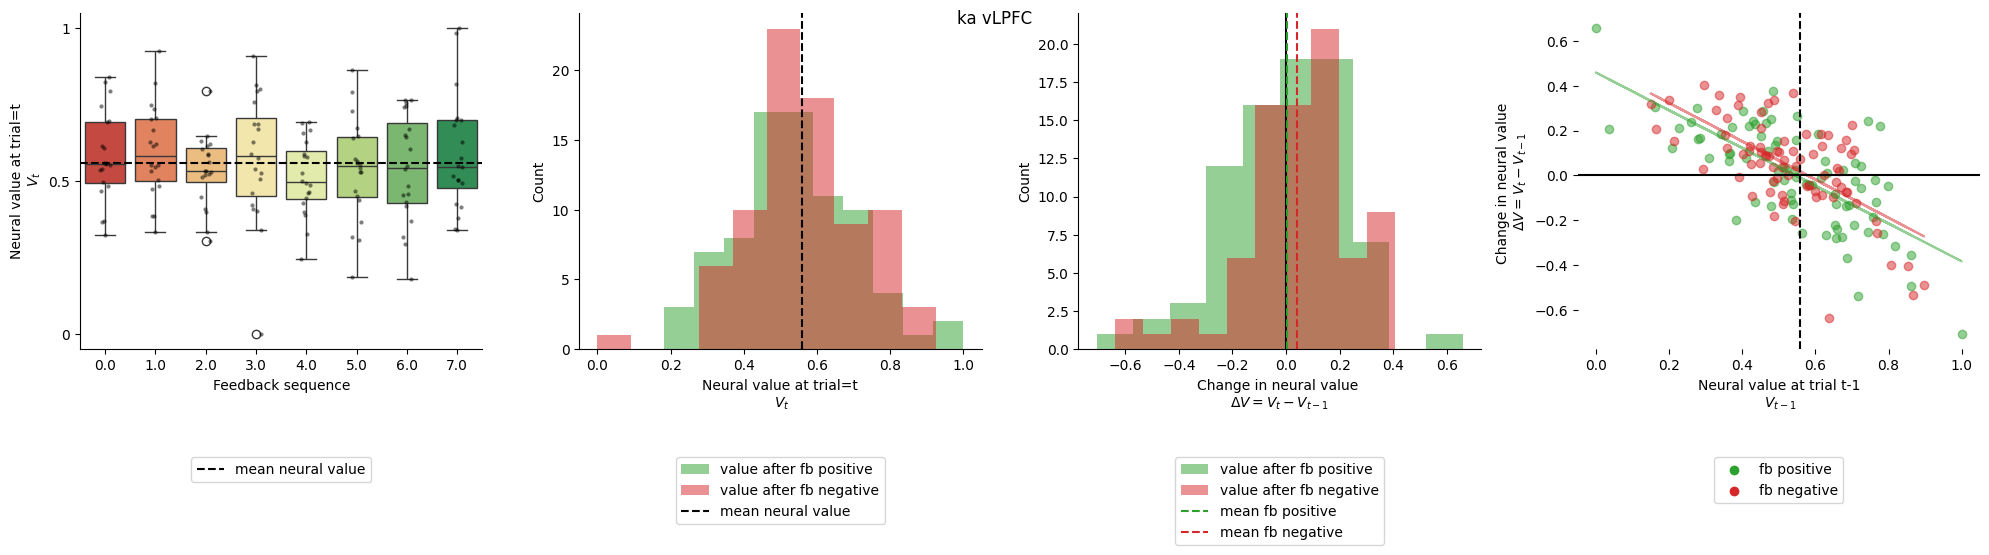

In [10]:
fig, ax = green_red_plot(data_projected)
plt.suptitle(f'{monkey} {subregion}')

floc = '/Users/zsombi/ZSOMBI/SBRI/PoPy/notebooks/decoders/population_decoding/figs'
fig.savefig(os.path.join(floc, f'{monkey}_{subregion}_green_red_plot.png'), dpi=200)